# Compute Empirical Orthogonal Functions (EOFs) of your data

Using COAsT to compute the Empirical Orthogonal Functions (EOFs) of your data

### Relevant imports and filepath configuration

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Begin by importing coast and other packages
import coast
import xarray as xr
import matplotlib.pyplot as plt

/gws/smf/j04/canari/conda-env/lib/python3.10/site-packages/pydap/lib.py:5: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
/gws/smf/j04/canari/conda-env/lib/python3.10/site-packages/pkg_resources/__init__.py:2846: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('pydap')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
/gws/smf/j04/canari/conda-env/lib/python3.10/site-packages/pkg_resources/__init__.py:2846: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('pydap.responses')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
/gws/smf/j04/canari/conda-

In [5]:
data_path = "/gws/nopw/j04/canari/shared/large-ensemble/priority/HIST2/1/OCN/yearly/1950"
fn_nemo_dat_t = f"{data_path}/cv575o_1_mon__grid_T_sossheig.nc"
fn_nemo_dom = "/gws/nopw/j04/canari/users/dlrhodso/mesh_mask.nc"
config_t = "../config/example_nemo_grid_t.json"

### Loading data

In [6]:
t_data = xr.open_mfdataset(fn_nemo_dat_t)
nemo = coast.Gridded(t_data, fn_nemo_dom, config=config_t)

In [7]:
# nemo = nemo.isel(t_dim=[0,1])

In [8]:
# ind_2d = nemo.subset_indices(start=[51,-4], end=[62,15])
ind_2d = nemo.subset_indices(start=[40,-20], end=[65,15])
nemo_nwes = nemo.isel(y_dim=ind_2d[0], x_dim=ind_2d[1])

### Compute EOF

For a variable (or subset of a variable) with two spatial dimensions and one temporal dimension, i.e. (x,y,t), the EOFs, temporal projections and variance explained can be computed by calling the ‘eofs’ method, and passing in the ssh DataArray as an argument. For example, for the sea surface height field, we can do

In [9]:
eof_data = coast.compute_eofs( nemo_nwes.dataset.ssh )

The method returns an xarray dataset that contains the EOFs, temporal projections and variance as DataArrays

In [10]:
eof_data  # uncomment to print data object summary

<xarray.Dataset> Size: 1MB
Dimensions:        (mode: 12, y_dim: 175, x_dim: 103, t_dim: 12)
Coordinates:
  * mode           (mode) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
    y              (y_dim) float64 1kB 858.0 859.0 860.0 ... 1.031e+03 1.032e+03
    x              (x_dim) float64 824B 1.069e+03 1.07e+03 ... 1.171e+03
    longitude      (y_dim, x_dim) float32 72kB -19.94 -19.69 ... 14.72 15.0
    latitude       (y_dim, x_dim) float32 72kB 39.94 39.94 39.94 ... 64.94 64.88
    time           (t_dim) object 96B 1950-01-16 00:00:00 ... 1950-12-16 00:0...
Dimensions without coordinates: y_dim, x_dim, t_dim
Data variables:
    EOF            (y_dim, x_dim, mode) float32 865kB 0.004666 0.0004727 ... nan
    temporal_proj  (t_dim, mode) float32 576B 2.367 -4.334 ... 0.1227 4.253e-06
    variance       (mode) float32 48B dask.array<chunksize=(12,), meta=np.ndarray>

### Inspect EOFs
The variance explained of the first four modes is

In [11]:
eof_data.variance.sel(mode=[1,2,3,4,5,6])  ## uncomment

<xarray.DataArray 'variance' (mode: 6)> Size: 24B
dask.array<getitem, shape=(6,), dtype=float32, chunksize=(6,), chunktype=numpy.ndarray>
Coordinates:
  * mode     (mode) int64 48B 1 2 3 4 5 6
Attributes:
    standard name:  percentage of variance explained

### Plotting
And the EOFs and temporal projections can be quick plotted:

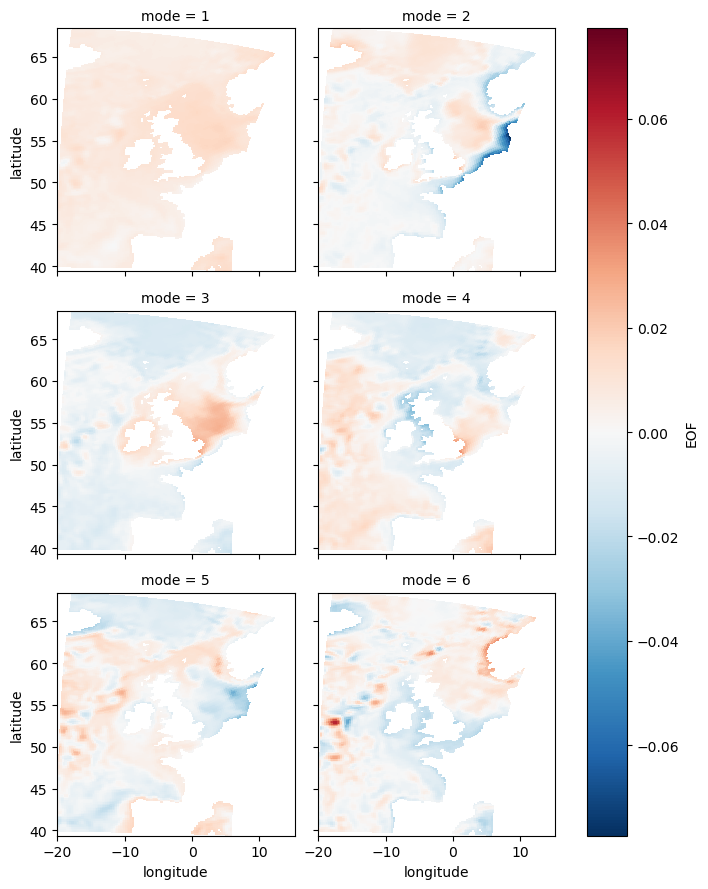

In [12]:
eof_data.EOF.sel(mode=[1,2,3,4,5,6]).plot.pcolormesh(col='mode',col_wrap=2,x='longitude',y='latitude')

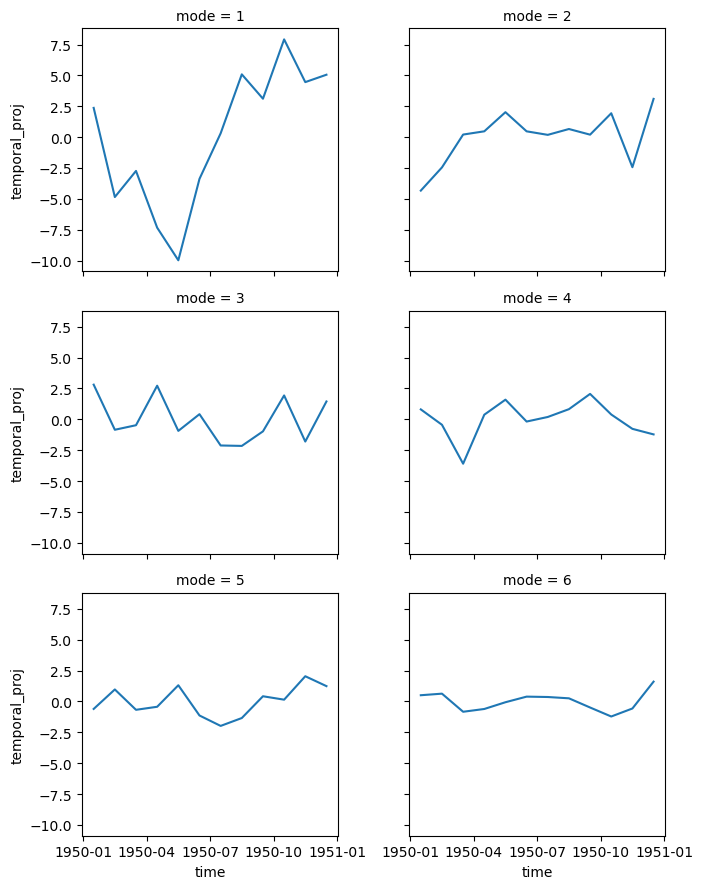

In [13]:
eof_data.temporal_proj.sel(mode=[1,2,3,4,5,6]).plot(col='mode',col_wrap=2,x='time')

### Complex EOFs
The more exotic hilbert complex EOFs can also be computed to investigate the propagation of variability, for example:

In [14]:
heof_data = coast.compute_hilbert_eofs(nemo_nwes.dataset.ssh )
heof_data # uncomment to print data object summary

<xarray.Dataset> Size: 2MB
Dimensions:         (mode: 12, y_dim: 175, x_dim: 103, t_dim: 12)
Coordinates:
  * mode            (mode) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
    y               (y_dim) float64 1kB 858.0 859.0 ... 1.031e+03 1.032e+03
    x               (x_dim) float64 824B 1.069e+03 1.07e+03 ... 1.171e+03
    longitude       (y_dim, x_dim) float32 72kB -19.94 -19.69 ... 14.72 15.0
    latitude        (y_dim, x_dim) float32 72kB 39.94 39.94 ... 64.94 64.88
    time            (t_dim) object 96B 1950-01-16 00:00:00 ... 1950-12-16 00:...
Dimensions without coordinates: y_dim, x_dim, t_dim
Data variables:
    EOF_amp         (y_dim, x_dim, mode) float32 865kB 0.004849 0.003756 ... nan
    EOF_phase       (y_dim, x_dim, mode) float32 865kB 97.44 80.04 ... nan nan
    temporal_amp    (t_dim, mode) float32 576B 10.34 4.771 ... 3.227e-07
    temporal_phase  (t_dim, mode) float32 576B 0.0 180.0 180.0 ... -95.92 -80.67
    variance        (mode) float32 48B 77.44 11.44 5.82 ... 4.31e-14 3.456e-14

now with the modes expressed by their amplitude and phase, the spatial propagation of the variability can be examined through the EOF_phase.
